In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-100k/ml-100k/u.occupation
/kaggle/input/ml-100k/ml-100k/u1.base
/kaggle/input/ml-100k/ml-100k/u.info
/kaggle/input/ml-100k/ml-100k/u4.test
/kaggle/input/ml-100k/ml-100k/u.item
/kaggle/input/ml-100k/ml-100k/README
/kaggle/input/ml-100k/ml-100k/u1.test
/kaggle/input/ml-100k/ml-100k/ua.test
/kaggle/input/ml-100k/ml-100k/u.data
/kaggle/input/ml-100k/ml-100k/u5.test
/kaggle/input/ml-100k/ml-100k/mku.sh
/kaggle/input/ml-100k/ml-100k/u5.base
/kaggle/input/ml-100k/ml-100k/u.user
/kaggle/input/ml-100k/ml-100k/ub.base
/kaggle/input/ml-100k/ml-100k/u4.base
/kaggle/input/ml-100k/ml-100k/u2.test
/kaggle/input/ml-100k/ml-100k/ua.base
/kaggle/input/ml-100k/ml-100k/u3.test
/kaggle/input/ml-100k/ml-100k/u.genre
/kaggle/input/ml-100k/ml-100k/allbut.pl
/kaggle/input/ml-100k/ml-100k/u3.base
/kaggle/input/ml-100k/ml-100k/u2.base
/kaggle/input/ml-100k/ml-100k/ub.test


### importing the required libraries

In [30]:
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.neighbors import NearestNeighbors

### reading the data files

In [31]:
# reading users file:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/kaggle/input/ml-100k/ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

# reading ratings file:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('/kaggle/input/ml-100k/ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

# reading items file:
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('/kaggle/input/ml-100k/ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')

### lets take a peek at the dataset

In [32]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [33]:
items.tail()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1681,1682,Scream of Stone (Schrei aus Stein) (1991),08-Mar-1996,NaN,http://us.imdb.com/M/title-exact?Schrei%20aus%...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### creating a user. preference which contains the user-id,movie title and rating

In [34]:
id_ =  items['movie id'].to_list()
movie_name  = items['movie title'].to_list()

movie_id = {x:y for x,y in zip(id_ , movie_name)}

ratings['movie_title'] = ratings.movie_id.replace(movie_id)

user_preference =  ratings[['user_id','movie_title','rating']]

### lets take a peek at the user preference

In [35]:
user_preference.head()

,user_id,movie_title,rating
0,196,Kolya (1996),3
1,186,L.A. Confidential (1997),3
2,22,Heavyweights (1994),1
3,244,Legends of the Fall (1994),2
4,166,Jackie Brown (1997),1


### lets see the trend in the total rating per user

In [36]:
user_by_rating = user_preference.groupby('user_id').rating.count()
user_by_rating = user_by_rating.reset_index()
user_by_rating.columns = ['user_id','no_rating_given_by_user']
user_by_rating.head()

,user_id,no_rating_given_by_user
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175


<AxesSubplot:ylabel='Frequency'>

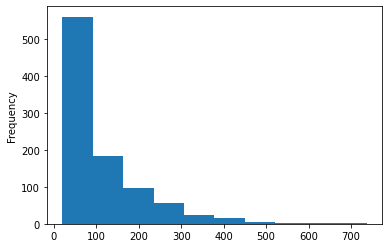

In [37]:
user_by_rating.sort_values(by ='no_rating_given_by_user' ).no_rating_given_by_user.plot(kind ='hist')

### lets create a function that recommends similar users to the target user

In [38]:
def recommend_users(user_preference,user_id =1,return_n_users  = 5,metric_to_use = 'cosine'):
    #Generates a matrix of movies title and userid with the corresponding rating as the values
    data_matrix = user_preference.pivot_table(values = 'rating',columns ='movie_title',index ='user_id').fillna(0)


    print('list of available metrics: \n',sklearn.neighbors.VALID_METRICS['brute'])
    # knn model for selecting similary users
    user_knn_model = NearestNeighbors(n_neighbors=100,metric=metric_to_use, algorithm='brute', n_jobs=-1)
    user_knn_model.fit(data_matrix)
    
    # index of target user
    query_index = user_id - 1
    # predict n similar users 
    distances, indices = user_knn_model.kneighbors(data_matrix.iloc[query_index,:].values.reshape(1, -1),n_neighbors=return_n_users+1)
    
    # a list of user_id  that are similar to target_user id
    top_n_users = indices[0][1:] # return a data matrix of movies title and userid with the corresponding rating as the values for only user_id that is similar to the target
    return data_matrix.iloc[top_n_users]

### lets create a function that recommends similar movies to the target movie

In [39]:
def recommmend_movies(similar_users_data_matrix,movie_title = 'Legends of the Fall (1994)',return_n_movies  = 3,metric_to_use = 'cosine'):
    #Generates a  Transposed matrix of movies title and userid with the corresponding rating as the values for similar users
    movie_data_matrix = similar_users_data_matrix.T 
    
    # Generates a dictionary of movie to index 
    unique_movie_list = movie_data_matrix.index
    movie_title_index = {unique_movie_list[index]:index  for index in range(len(unique_movie_list))}
    # knn model for selecting similary movies
    knn_model = NearestNeighbors(n_neighbors=100,metric=metric_to_use, algorithm='brute', n_jobs=-1)
    knn_model.fit(movie_data_matrix)
    
    # index of target movie
    query_index = movie_title_index[movie_title]
    
    # predict similar n movies
    distances, indices = knn_model.kneighbors(movie_data_matrix.iloc[query_index,:].values.reshape(1, -1),n_neighbors=return_n_movies+1)
    
    # list of all similar movie names
    top_n_movies = [movie_data_matrix.index[indices.flatten()][movie] for movie in range(1,len(indices[0]))]
    top_n_movies_distance =  distances[0][1:]
    top_movies_and_distances_from_target  = pd.DataFrame(np.array([top_n_movies,top_n_movies_distance]).T,columns  = ['top_n_movies',metric_to_use +'_distance_top_n_movies'])
     
    
    return top_movies_and_distances_from_target

### lets create a function that returns a list of popular movies i.e rating count > 150

In [40]:
def highly_rated_movies(user_preference):
    # Generates a count of movies reviews per movie
    movie_by_rating = user_preference.groupby('movie_title',).rating.count()
    movie_by_rating = movie_by_rating.reset_index()
    movie_by_rating.columns = ['movie_title','no_rating_recieved_by_movie']
    # Return movies with more than 150 ratings
    top_movies = movie_by_rating[movie_by_rating.no_rating_recieved_by_movie > 150].movie_title.to_list()
    return top_movies

### lets create a function that recommends movies to a user based on the user's favorite movie

In [41]:
def recommend_movies_to_users_favourite(user_preference,metric_to_use = 'correlation'):
    # Enter the target user ID
    target_user = int(input('Enter the target_id of the user: '))
    fav_movie = input('Enter the favourite movie of the user: ')
    # Generates a list of movies with high rating counts
    top_movies_with_reviews =  highly_rated_movies(user_preference)
    
    # Generates an array of interesting movies previously watched by the target user i.e movies the target user gave a rating of 5
    movies_watched_by_target_user =  user_preference[(user_preference.user_id == target_user) & (user_preference.rating >=5)].movie_title.unique()
    # Generate similar users to target users
    similar_users_preference = recommend_users(user_preference = user_preference,user_id=target_user,metric_to_use=metric_to_use)
    
    
    
    # similar movies to nth target movie
    movies_for_selected_user =  recommmend_movies(similar_users_preference,movie_title=fav_movie,metric_to_use=metric_to_use)
    # Generate a set of the generated similar movies 
    total_unique_movies_recommended = movies_for_selected_user.top_n_movies.unique()
    # Generate a list of recommended movies that have been watched by the target user
    true_recommended_movies =  [movie for movie in total_unique_movies_recommended if movie not in movies_watched_by_target_user]
    # Generate a list of recommended movies that is among the highly rated movies
    #final_movies_recomendation = [movie for movie in true_recommended_movies if movie in top_movies_with_reviews]
    # return highly rated recommended movies
    return true_recommended_movies

### lets create a function that recommends movies automatically to a user based on the movies the user has watched in the past

In [42]:
def recommend_movies_to_users_automatically(user_preference,metric_to_use = 'correlation'):
    # Enter the target user ID
    target_user = int(input('Enter the target_id of the user: '))
    # Generates a list of movies with high rating counts
    top_movies_with_reviews =  highly_rated_movies(user_preference)
    
    # Generates an array of interesting movies previously watched by the target user i.e movies the target user gave a rating of 5
    movies_watched_by_target_user =  user_preference[(user_preference.user_id == target_user) & (user_preference.rating >=5)].movie_title.unique()
    # Generate similar users to target users
    similar_users_preference = recommend_users(user_preference = user_preference,user_id=target_user,metric_to_use=metric_to_use)
    
    
    # A DataFrame for storing all similar recommended movies
    total_movies_recommended_for_target_user = pd.DataFrame()
    
    #Find similar movies to each movie that the target user has watched before 
    for movie in movies_watched_by_target_user:
        # similar movies to nth target movie
        movies_for_selected_user =  recommmend_movies(similar_users_preference,movie_title=movie,metric_to_use=metric_to_use)
        # append nth similar movie to total movies recommended for the target user
        total_movies_recommended_for_target_user = pd.concat([total_movies_recommended_for_target_user,movies_for_selected_user])
    # Generate a set of the generated total similar movies 
    total_unique_movies_recommended = total_movies_recommended_for_target_user.top_n_movies.unique()
    # Generate a list of recommended movies that have been watched by the target user
    true_recommended_movies =  [movie for movie in total_unique_movies_recommended if movie not in movies_watched_by_target_user]
    # Generate a list of recommended movies that is among the highly rated movies
    final_movies_recomendation = [movie for movie in true_recommended_movies if movie in top_movies_with_reviews]
    # return highly rated recommended movies
    return final_movies_recomendation

In [43]:
def recommendation_engine(user_preference, metric_to_use = 'correlation'):
    # Determine whether automatic recommendation or based on fav movie
    recommendation_type  = int(input('Enter 1 for automatic recommendation or 2 for recommendation based oon the users favorite movie'))
    
    if recommendation_type == 1:
        movies = recommend_movies_to_users_automatically(user_preference,metric_to_use = metric_to_use)
        print(movies)
    elif recommendation_type == 2:
        movies =recommend_movies_to_users_favourite (user_preference, metric_to_use)
        print (movies)
    else:
        print('wrong input \n')
        recommendation_engine(user_preference)
        
    to_quit = int(input('enter 0 to continue or 1 to qiut'))
    if to_quit ==  1:
        print('Thanks for using this movie recommender')
        
    else:
        recommendation_engine(user_preference)
        

In [44]:
recommendation_engine(user_preference)

Enter 1 for automatic recommendation or 2 for recommendation based oon the users favorite movie 1
Enter the target_id of the user:  2


list of available metrics: 
 ['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean', 'braycurtis', 'canberra', 'chebyshev', 'correlation', 'cosine', 'dice', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule', 'wminkowski']
['Sabrina (1995)', 'Jerry Maguire (1996)', 'Air Force One (1997)', 'Dead Man Walking (1995)', 'Grosse Pointe Blank (1997)', 'Contact (1997)', 'Fifth Element, The (1997)', "Devil's Own, The (1997)", 'Evita (1996)', 'Lone Star (1996)', 'Toy Story (1995)', 'English Patient, The (1996)', "Ulee's Gold (1997)", 'Fly Away Home (1996)', 'Apt Pupil (1998)', 'Seven Years in Tibet (1997)', 'That Thing You Do! (1996)']


enter 0 to continue or 1 to qiut 1


Thanks for using this movie recommender
